# CHAPTER 18 - Learning 

### George Tzanetakis, University of Victoria 


## WORKPLAN 

The section number is based on the 3th edition of the AIMA textbook and is the suggested
reading for this week. Each list entry provides just the additional sections. For example the Expected reading include the sections listed under Basic as well as the sections listed under Expected. Some additional readings are suggested for Advanced.
In the 4th edition of the AIMA textbook this notebook corresponds to Chapter 19. 

1. Basic: Sections **18.1**, **18.2**, and **Summary**
2. Expected: Same as Basic plus **18.3**, **18.6**, **18.7**
3. Advanced: All the chapter including bibligraphical and historical notes 






# Forms of learning  

An agent is **learning** if it improves its performance on future tasks after making observations about the world. 
In this chapter, we focus on a simple type of learning problem which is given a collection of input-output pairs, learn 
a function that predicts the output for new inputs. Even though at first glance this seems like a simple learning problem 
it has a large number of applications. 

## Feedback to learn from 

There are *types of feedback* that determine the three main types of learning: 

* **Unsupervised learning:** the agent learns patterns in the input without any explicit feedback. The most common example of unsuprvised learning is **clustering**
* **Reinforcement learning:** the agent learns from a series of reinforcements (rewards and punishments).
* **Supervised learning:** the agent observes some example input/output pairs and learns a function that maps the input to output. 




In [1]:
import numpy as np
mu = 3.0 
sigma = 0.2 
s = np.random.normal(mu, sigma, 10)
print(s)

[2.89688082 3.12786894 2.95647838 3.08751238 2.73587973 3.21663023
 2.63526193 3.08652592 2.92396872 3.10596726]


In [2]:
samples = np.random.normal(mu, sigma, 10000)
print(len(samples))

10000



## Simple Naive Bayes binary classification example

In this notebook I will show a very simple example of this idea. Hopefully this will give you some general intuition about this approach. Then you can review the specific book examples that are more complicated (learning Gaussian mixtures, Bayesian networks with hidden variables, and learning hmm parameters). We will end by showing the general mathematical notation. 



Let's consider a simple binary classification problem with one continous attribute. For example this could be classifying whether some one is a professional basketball player or not based on their height. We can generate some synthetic data for this problem by simply sampling two Gaussian distribution. Let's say that professional basketball players have an average height of 190cm and the average height of other people is 175cm. For simiplicity we will consider they both have a standard deviation of 10cm. 

In [3]:
import numpy as np

# generate twenty samples of each class 
bball_samples = np.random.normal(190, 10, 20)
other_samples = np.random.normal(175, 10, 20)
print(bball_samples)
print(other_samples)

[179.12413644 204.13250537 186.68074233 196.62463334 197.13572049
 200.51359863 199.65044778 200.78821901 194.91212774 195.34903025
 206.81646482 213.95067429 201.86089629 185.55141793 181.00412699
 187.5864391  189.10177398 190.72338643 188.99896753 192.42639147]
[185.77964706 170.1563388  201.63124775 178.68264322 169.41625806
 183.34219145 191.67777688 168.77927396 181.62997644 177.61642162
 180.83314659 155.31029658 186.92168663 171.5683143  191.06541306
 183.79604541 170.84556428 177.80031965 179.37617735 170.61949384]


In [4]:
# generate 1000 samples of each class and plot histogram 

bball_mean_height = 190 
other_mean_height = 175 
bball_samples = np.random.normal(bball_mean_height, 10, 100)
other_samples = np.random.normal(other_mean_height, 10, 100)

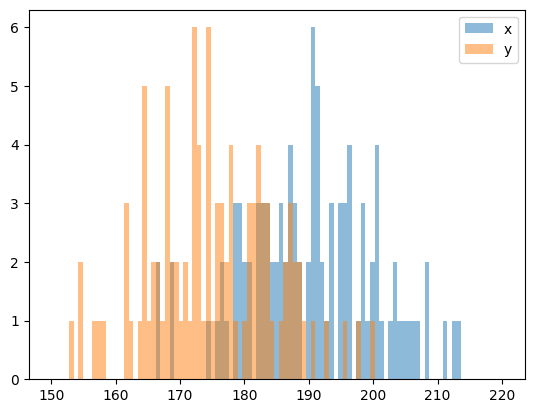

In [5]:
from matplotlib import pyplot
bins = np.linspace(150, 220, 100)
pyplot.hist(bball_samples, bins, alpha=0.5, label='x')
pyplot.hist(other_samples, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

You can clearly see in the histogram the height-distribution and overlap. You can also see that there is an equal number of instances for each class and that the standard deviation is the same.

Now suppose that you are just given the nba_samples and other_samples and told that these are labeled samples for training a Naive Bayes classifier. You also know that they both have a standard deviation of 10cm so we will keep that. In this case the only parameter we are trying to estimate is the mean of each class. So 𝜃=(𝜇𝑛𝑏𝑎,𝜇𝑜𝑡ℎ𝑒𝑟).

Given this data the maximum-likelihood estimate for the means is easily obtained by taking the statistical mean of the samples.

In [6]:
mu_bball = np.mean(bball_samples)
mu_other = np.mean(other_samples)
print(mu_bball, mu_other)

190.30141964602342 175.0521880125643


Now that we have "learned" a model we can use it to predict. Suppose you are given a test height - lets say 183cm. You can calcuate the $P(183/nba)$ and $P(183/other)$ by using the corresponding probability density functions characterized by $\mu_{nba}$ and $\sigma = 10$ and $\mu_{other}$ and $\sigma = 10$. 

In [7]:
from scipy.stats import norm

test_height = 200

p_bball = norm(mu_bball, 10).pdf(test_height)
p_other = norm(mu_other, 10).pdf(test_height)
print(p_bball, p_other)

if (p_bball > p_other): 
    print(str(test_height) + " is more likely a professional basketball player")
else: 
    print(str(test_height) + " is more likely NOT a professional basketball player")


0.024926197239384128 0.001775824883332331
200 is more likely a professional basketball player


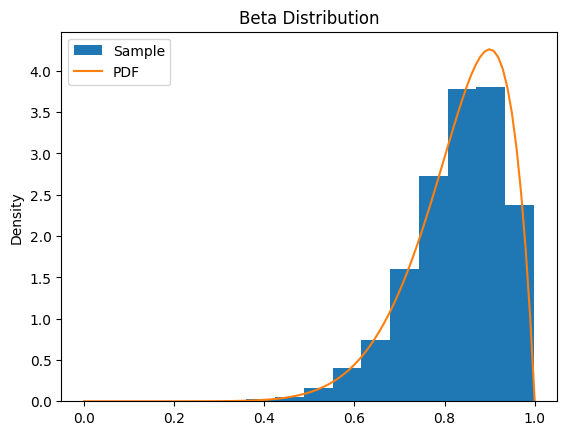

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
beta=stats.beta(a=10,b=2)
beta_sample=beta.rvs(size=1000,random_state=133)
t=np.linspace(0,1,100)
plt.hist(beta_sample,density=True,label="Sample")
plt.plot(t,beta.pdf(t),label="PDF")
plt.legend()
plt.ylabel("Density")
plt.title("Beta Distribution")
plt.savefig("beta_hist_pdf.png")
plt.show()

## Learning Decision Trees 




A **decision tree** represents a function that takes as input a vector of attribute values and return a **decision** - a single output value. The input and output values can be discrete or continuous. To make things simple we will focus initially on discrete attributes and a single binary output (true or false)(positive or negative). 

A decision tree makes a decision by performing a sequence of test. Each node in the tree corresponds to a test of the value of one of the input attributes $A_i$ and the branches from the node are labeled with the possible values of the attribute. Each leaf node in the tree specifies a value to be return by the function. 

One way to think of a decision tree is as through propositional logic. The goal attribute is true if and only if the input attributes satisfy one of the paths leading to a leaf with value *true*: 

$$
Goal <=> (Path_{1} \lor Path_{2} \lor \dots)
$$

Each path is a conjuction of attribute-value tests required to follow the path. 

## Inducing decision trees from examples


An instance or example that can be used to "train" a decision tree consists of an $(\bf{x},y)$ pair, where $x$ is a vector of values for the input attributes, and $y$ is a single output value. This is called the target (or goal) attribute and corresponds to whether $WillWait$ is $true$ or $false$. 

<img src="images/decision_tree_attributes.png" width="100%"/>


<img src="images/decision_tree.png" width="100%"/>


Ideally we would want the smallest possible tree that is consistent with the examples. However, this is an intractable problem as there are $2^{2^{n}}$ trees to consider. We can do a decent job using a greedy divide and conquer strategy. 

1. Choose a "good" attribute to split
2. If all examples after a split are positive (or negative) then return the corresponding classification 
3. Create two subproblems based on the split
4. Recursively repeat the process until there are no attributes left to split 
5. When there are are both positive and negative examples use plurality to make decision


<img src="images/decision_tree_attribute_splits.png" width="100%"/>

<img src="images/decision_tree_learning_algorithm.png" width="100%"/>

<img src="images/induced_decision_tree.png" width="100%"/>


## Choosing attribute tests

We need a formal measure of "fairly good" and "really useless" to implement the $IMPORTANCE$ function. We will use the notation of information gain, which is defined in term of **entropy**, the fundamental quantity in information theory. 

**Entropy** of random variable: 

$$ 
H(V) = \sum_{k} P(v_k) \log_{2} \frac{1}{P(v_k)} = - \sum_{k} P(v_k) \log_2P(v_k)
$$

For example the entropy of a fair coin is 1 bit: 
$$
H(Fair) = -(0.5 \log_2 0.5 + 0.5 \log_2 0.5) = 1
$$

If *Loaded* is a random coin with $0.99$ probability of being Head and $0.01$ probability of being tail we get: 

$$
H(Loaded) = -(0.99 \log_2 0.99 + 0.01 \log_2 0.01) \approx 0.08 bits
$$

Let's definte $B(q)$ as the entropy of a Boolean random variable that is true with probability $q$: 
$$
B(q) = -\left (q \log_2 q + (1-q) \log_2 (1 - q)\right)
$$

If the training set contains $p$ positive examples and $n$ negative examples then the entropy of the target attribute on the whole set is: 
$$ 
H(Goal) = B\left(\frac{p}{p+n}\right)
$$

For example the restaurant training set has $p=n=6$ so the corresponding entropy is $B(0.5) = 1$. A test on a single attribute(feature) might give us only part of this 1 bit. We can measure exactly how much by looking at the entropy remaining after the attribute test. 
Suppose that an attribute A with $d$ distinct values divides the training set $E$ into subset $E_1, \dots E_d$. Each subset $E_k$ has $p_k$ positive examples and $n_k$ negative examples so if we go along that branch we need an additional $B(p_k/(p_k +n_k)$ bits of information to answer the question. A randomly chosen example from the training set has the kth value for the attribute with probability $(p_k + n_k)/(p + n)$, so the expected entropy remaining after testing attribute $A$ is 
$$ 
Remainder(A) = \sum_{k=1}^{d} \frac{(p_k + n_k)}{p+n} B\left(\frac{p_k}{p_k+n_k}\right)
$$

The **information gain** from the attribute test on $A$ is expected reduction in entropy: 
$$ 
Gain(A) = B\left(\frac{p}{p+n}\right) - Remainder(A) 
$$

For example consider the attributes from our example we have: 

$$ 
Gain(Patrons) = 1 - \left[\frac{2}{12} B\left(\frac{0}{2}\right) + \frac{4}{12}B\left(\frac{4}{4}\right)+ \frac{6}{12}B\left(\frac{2}{6}\right)\right] \approx 0.541 bits
$$
$$ 
Gain(Type) = 1 - \left[\frac{2}{12} B\left(\frac{1}{2}\right) + \frac{2}{12}B\left(\frac{1}{2}\right)+ \frac{4}{12}B\left(\frac{2}{4}\right) + \frac{4}{12}B\left(\frac{2}{4}\right)\right] = 0  bits
$$


### Additional topics 

* Overfitting
* Decision tree pruning
* Signficance test
* Early stopping
* Missing data
* Multi-valued attributes
* Continuous and integer-valued input attributes
* Continuous-valued output attributes

One **important property** of decision trees is that it is possible for a human to understand the reason for the output of the learning algorithm. This can be a **legal requirement** for financial decisions and is not the case in other learned representations such as neural networks. 

In [9]:

import pandas as pd 
import numpy as np

data = np.array([['Yes', 'No', 'No', 'Yes', 'Some', '3D', 'No', 'Yes', 'French', '0_10', 'Yes'], 
                 ['Yes', 'No', 'No', 'Yes', 'Full', '1D', 'No', 'No', 'Thai', '30_60', 'No'],
                 ['No' , 'Yes', 'No', 'No', 'Some', '1D', 'No', 'No',  'Burger', '0_10', 'Yes'],
                 ['Yes' ,'No', 'Yes', 'Yes', 'Full', '1D', 'Yes', 'No', 'Thai', '10_30', 'Yes'],
                 ['Yes', 'No', 'Yes' ,'No' ,'Full', '3D', 'No', 'Yes', 'French', '>60', 'No'],
                 ['No',  'Yes', 'No', 'Yes', 'Some','2D', 'Yes', 'Yes', 'Italian', '0_10', 'Yes'], 
                 ['No', 'Yes' , 'No' , 'No' , 'None' ,'1D', 'Yes', 'No', 'Burger', '0_10', 'No'], 
                 ['No', 'No', 'No', 'Yes', 'Some', '2D', 'Yes', 'Yes', 'Thai', '0_10', 'Yes'], 
                 ['No', 'Yes','Yes', 'No', 'Full', '1D', 'Yes', 'No', 'Burger', '>60', 'No'],
                 ['Yes', 'Yes', 'Yes', 'Yes', 'Full', '3D', 'No', 'Yes', 'Italian', '10_30', 'No'],
                 ['No', 'No', 'No', 'No', 'None', '1D', 'No', 'No', 'Thai', '0_10', 'No'],
                 ['Yes','Yes','Yes','Yes','Full', '1D', 'No', 'No', 'Burger','30_60', 'Yes']
                ]
               )

feature_names = ['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type', 'Est'] 
target_name   = 'WillWait'
df = pd.DataFrame(data, columns = feature_names + [target_name])
print(df)


    Alt  Bar  Fri  Hun   Pat Price Rain  Res     Type    Est WillWait
0   Yes   No   No  Yes  Some    3D   No  Yes   French   0_10      Yes
1   Yes   No   No  Yes  Full    1D   No   No     Thai  30_60       No
2    No  Yes   No   No  Some    1D   No   No   Burger   0_10      Yes
3   Yes   No  Yes  Yes  Full    1D  Yes   No     Thai  10_30      Yes
4   Yes   No  Yes   No  Full    3D   No  Yes   French    >60       No
5    No  Yes   No  Yes  Some    2D  Yes  Yes  Italian   0_10      Yes
6    No  Yes   No   No  None    1D  Yes   No   Burger   0_10       No
7    No   No   No  Yes  Some    2D  Yes  Yes     Thai   0_10      Yes
8    No  Yes  Yes   No  Full    1D  Yes   No   Burger    >60       No
9   Yes  Yes  Yes  Yes  Full    3D   No  Yes  Italian  10_30       No
10   No   No   No   No  None    1D   No   No     Thai   0_10       No
11  Yes  Yes  Yes  Yes  Full    1D   No   No   Burger  30_60      Yes


In [10]:
from sklearn import tree
from sklearn import preprocessing

categorical_features = df[feature_names]
orig_target = df[target_name]
print(categorical_features)
print(orig_target)
numerical_features = pd.DataFrame()
# Encode categorical variables
for f in feature_names: 
    numerical_features[f] = categorical_features[f].astype("category").cat.codes
target = orig_target.astype("category").cat.codes
print(numerical_features)
print(target)


    Alt  Bar  Fri  Hun   Pat Price Rain  Res     Type    Est
0   Yes   No   No  Yes  Some    3D   No  Yes   French   0_10
1   Yes   No   No  Yes  Full    1D   No   No     Thai  30_60
2    No  Yes   No   No  Some    1D   No   No   Burger   0_10
3   Yes   No  Yes  Yes  Full    1D  Yes   No     Thai  10_30
4   Yes   No  Yes   No  Full    3D   No  Yes   French    >60
5    No  Yes   No  Yes  Some    2D  Yes  Yes  Italian   0_10
6    No  Yes   No   No  None    1D  Yes   No   Burger   0_10
7    No   No   No  Yes  Some    2D  Yes  Yes     Thai   0_10
8    No  Yes  Yes   No  Full    1D  Yes   No   Burger    >60
9   Yes  Yes  Yes  Yes  Full    3D   No  Yes  Italian  10_30
10   No   No   No   No  None    1D   No   No     Thai   0_10
11  Yes  Yes  Yes  Yes  Full    1D   No   No   Burger  30_60
0     Yes
1      No
2     Yes
3     Yes
4      No
5     Yes
6      No
7     Yes
8      No
9      No
10     No
11    Yes
Name: WillWait, dtype: object
    Alt  Bar  Fri  Hun  Pat  Price  Rain  Res  Type  Est


In [11]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(numerical_features[feature_names].values, target.values)

DecisionTreeClassifier()

[Text(0.5, 0.9, 'x[4] <= 1.5\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(0.3333333333333333, 0.7, 'x[3] <= 0.5\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.16666666666666666, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.5, 0.5, 'x[8] <= 1.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.3333333333333333, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6666666666666666, 0.3, 'x[6] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8333333333333334, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6666666666666666, 0.7, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]')]

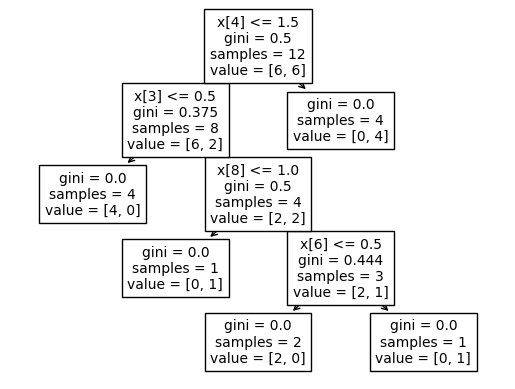

In [12]:
tree.plot_tree(clf)

In [13]:
import dtreeviz
import matplotlib.font_manager

In [14]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

viz_model = dtreeviz.model(clf,
                           X_train=numerical_features[feature_names], y_train=target,
                           feature_names=feature_names,
                           target_name=target_name, class_names=["Yes", "No"])

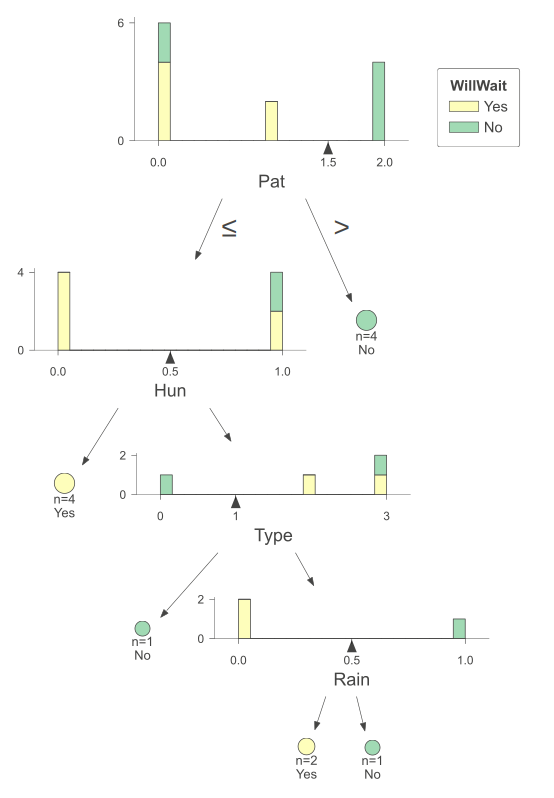

In [15]:
viz_model.view(scale=2.0)


## Evaluating and choosing the best hypothesis 


When learning a machine learning model we want the model to perform "well" on "future data" not just the data that it was trained on. In order to be more precise we need to define what we mean by "well" and "future data". To do this we will make the **stationarity assumption**: that there is a probability distribution over the examples that does not change over time. Each example data point is random variable $E_j$ who observed value $e_j = (x_j, y_j)$ is sampled from that distribution and is independent of the previous examples: 
$$ 
{\bf P}(E_j | E_{j-1}, E_{j-2}, \dots) = {\bf P}(E_j)
$$, 
and each example has an identical prior probability distribution: 
$$
{\bf P}(E_j) = {\bf P}(E_{j-1}) = {\bf P}(E_{j-2}) = \dots 
$$

Examples that satisfy these assumptions are called independent and identically distributed or **i.i.d**. 

### Error rate 

The **error rate** of a hypothesis/model is the proportion of mistakes it makes - the proportion of 
times that the output of the model $h(x) \neq y$ for an $(x,y$ example. The key observation is that because a hypothesis $h$ has a low error on the training set this deos not mean that it will generalize well. So in order to get an accurate idea of how well a particular model does we need to 
test it on examples it has not seen yet (i.e they have not been used for training). 

The simplest approach which is called **Hold-out cross-validation** is to randomly split the available labeled data into a training set from which the learning algorithm produces a hypothesis $h$ and a test set on which the accuracy of $h$ is evaluated. There are two challenges with this approach: not all data is used for training and it is unclear how much to use for training and how much to use for testing. 

A more sophisticated and pretty much standard approach in machine learning is what is called **k-fold cross-validation**. The labeled data is split into $k$ equal subsets (the folds). We then perform $k$ rounds of learning. In each round, one fold is held out as a test set and the remaining $k-1$ folds are used for training. 

**Peeking** occurs when adjustments are made on an algorithm based on how it is doing on the test set error rate. Information about the test set is leaked into the learning algorithm. To avoid this a common practice is to keep a test set completely separate and not evaluate it until all learning is complete. In order to otimize the model/learning algorithm instead a **validation** set can be used. 



## Univariate Linear Regression 

A very basic operation to consider is "fitting" a straight line. A univariate linear function with input $x$ and output $y$ has the form $y = w_1 x + w_o$ where $w_o$ and $w_1$ are real-valued coefficients to be learned. We use a vector $w$ instead of the more familiar $a$ and $b$ for reasons that will become apparent later. The vector $w$ is called the weights vector. So we have: 

$$ 
h_{\bf w}(x) = w_1 x + w_0
$$ 

Given a set of n training points on the plane, our task is to find the line that best fits these data points. This is called *linear regression*. We can use a squarred loss function $L_2$ summed over all the training examples: 

$$ 
Loss(h_{\bf w}) = \sum_{j=1}^{N} L_{2} (y_j, h_{\bf w}(x_j))) = \sum_{j=1}^{N}(y_j - h_{\bf w}(x_j))^2 = \sum_{j=1}^{N} (y_j - (w_{1} x_j+ + w_0))^2
$$




We would like to find $w^{*} = \text{argmin}_{\bf w} Loss(h_{\bf w})$ 




Setting the partial derivatives to $0$ with respect to $w_0$ and $w_1$ we can find the unique 
solution for $w_1$ and $w_0$. 

Many forms of learning involve adjusting weights to minimize a loss so we will look at linear regression from that perspective. One can think of the **weight space**, in linear regression a two dimensional space but in general a high dimensional space as the space defined by all possible settings of the weights. For linear regression there is a unique minimum and we can find it analytically. In most other cases in machine learning there is no close form solution and no single global minimum. 

Such problems can be addressed by a hill-climbing algorithm that follows the **gradient** of the function to be optimized. This is called **gradient descent**. The algorithm starts at any point in the weight space and then moves into a neighboring point that is downhill, repeating until we converge on the minimum possible loss. The weight update for gradient descent is: 

$$
w_i \leftarrow w_i - \alpha \frac{\partial }{\partial w_{i}} Loss({\bf w})
$$

The parameter $\alpha$, is called the **learning rate**. It can be a fixed constant, or it can decay over time as the learning process proceeds. For $N$ training examples, we want to minimize the sum of the individual losses for each example. The derivative of the sum is the sum of the derivatives so we have: 

$$
w_0 \leftarrow w_{0} + \alpha \sum_{j} (y_j - h_{\bf w}(x_j))
$$

$$ 
w_1 \rightarrow w_{1} + \alpha \sum_{j} (y_j - h_{\bf w}(x_j)) \times x_j 
$$ 

The updates constitute the **batch gradient descent** rule. An alternative is **stochastic gradient descent** where we consider only a random single training point at a time and taking an update step. 

It is straightforward to extend to **multi-variate linear regression**. 

$$
h_{\bf w}({\bf x_j}) = w_{0} + w_{1}x_{j,1} + \dots + w_n x_{j,n} = w_{0} + \sum_{j}{w_{i}x_{j,i}}
$$




A common trick used to make the notation more compact is to invent a dummy input attribute $x_j,0$ which is always equal to $1$. The $h$ is simply the dot-product of the weights and the input vector (or equivalently, the matrix product of the transpose of the weights and the input vector): 

$$
h_{w}({\bf x_{j}}) = {\bf w} \cdot {\bf x}_{j} = {\bf w}^{T} {\bf x}_{j} 
$$


The best vector of weight, ${\bf w}^{*}$, minimizes squarred-error loss over the examples: 

$$
{\bf w}{*} = \text{argmin}_{\bf w} \sum_{j} L_{2}(y_j, {\bf w} \cdot {\bf x_j})
$$

### Linear classification with a hard-threshold 


A **decision boundary** is a line (or surface) that separates two classes. A linear decision boundary is called a **linear separator** and data that admit such as a separator are called **linearly** separable. The classification hypothesis can be written as: 

 
$h_{\bf w} ({\bf x}) = 1$ if ${\bf w} \cdot {\bf x} \geq 0$  
and $0$ otherwise. 

One can think of this process as passing the output of the linear function ${\bf w} \cdot {\bf x}$ through a **threshold function**. 


### Perceptron Learning Rule 


Simple weight update scheme that converges to a solution (linear separator) that classifies the data perfectly provided the data is linearly separable. For a single example $({\bf x}, y)$ we have: 

$$ 
w_i \leftarrow w_i + \alpha (y - h_{\bf w} ({\bf x})) \times x_i
$$

If the output is correct the weights are left unchanged. If $y$ (the ground truth) is $1$ and the output $h_{\bf w}(\bf x)$ is $0$ then $w_i$ is increased. If $y$ is $0$ and the output is $1$ then $w_i$ is decreased. 



### Logistic Regression

In many cases, we are not just interested in a hard classification decision but would like to have a probability for each predicted class similarly to how we could get one from the Naive Bayes classifier. This is typically achieved by "softening" the threshold function and making it continuous and differentiable. 

The logistic function (also known as sigmoid) is defined as: 
$$
Logistic(z) = \frac{1}{1 + e^{-z}}
$$

There is no closed formed for logistic regression but gradient descent works in a straightforward way because the logistic function is easy to differentiate. 
